In [1]:
# Install packages as needed
!pip install git+https://github.com/paulgavrikov/visualkeras

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import visualkeras

from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-4c46_2mo
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-4c46_2mo
  Resolved https://github.com/paulgavrikov/visualkeras to commit d7111d3471173c0b16853a6ce5e4cc645498380a
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 8.0 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=a2bdadd2b0bab05e14f93b37b8ad9c43dfa3f5f1cf58d3a7f340addb692c3a3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-1n6dlwnx/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


In [2]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df

In [3]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

In [4]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

print("Total dataset size:", total_dataset_size)

Training set size: 18900 (70%)
Validation set size: 5400 (20%)
Test set size: 2700 (10%)
Total dataset size: 27000


In [5]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

batch_size = 128 # How big of a set of data to use for every training epoch


## Build train, validation, and test sets

In [6]:
"""
# Use a smaller batch size for initial implementation
# The data is not in order so simly using the first X rows should be fine
# Consider plotting class distribution to double check

print("Reducing data frame size for initial testing")

factor_reduction = 0.1 # only use 10 of the data
reduced_training = round(training_df_size*factor_reduction)
reduced_validation = round(validation_df_size*factor_reduction)
reduced_test = round(test_df_size*factor_reduction)

reduced_training_df = training_df[0:reduced_training]
reduced_validation_df = validation_df[0:reduced_validation]
reduced_test_df = test_df[0:reduced_test]

print(f"Reduced training set size: {len(reduced_training_df)}")
print(f"Reduced validation set size: {len(reduced_validation_df)}")
print(f"Reduced test set size: {len(reduced_test_df)}")

reduced_batch_size = round(batch_size*factor_reduction)

print(f"Reduced batch size: {reduced_batch_size}")
"""

'\n# Use a smaller batch size for initial implementation\n# The data is not in order so simly using the first X rows should be fine\n# Consider plotting class distribution to double check\n\nprint("Reducing data frame size for initial testing")\n\nfactor_reduction = 0.1 # only use 10 of the data\nreduced_training = round(training_df_size*factor_reduction)\nreduced_validation = round(validation_df_size*factor_reduction)\nreduced_test = round(test_df_size*factor_reduction)\n\nreduced_training_df = training_df[0:reduced_training]\nreduced_validation_df = validation_df[0:reduced_validation]\nreduced_test_df = test_df[0:reduced_test]\n\nprint(f"Reduced training set size: {len(reduced_training_df)}")\nprint(f"Reduced validation set size: {len(reduced_validation_df)}")\nprint(f"Reduced test set size: {len(reduced_test_df)}")\n\nreduced_batch_size = round(batch_size*factor_reduction)\n\nprint(f"Reduced batch size: {reduced_batch_size}")\n'

In [7]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size, # CHANGE BACK
    class_mode="categorical",
    shuffle=False, #for replicability. Anyways they are already shuffled?
)

print("\n Building validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size, # CHANGE BACK
    class_mode="categorical",
    shuffle=False,
)

print("\n Building test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size, # CHANGE BACK
    class_mode="categorical",
    shuffle=False
)


Building training set.
Found 18900 validated image filenames belonging to 10 classes.

 Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

 Building test set
Found 2700 validated image filenames belonging to 10 classes.


## Some data inspection

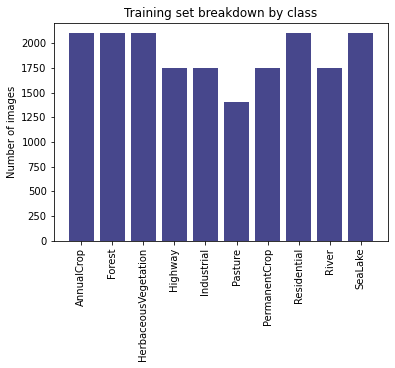

In [8]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

#print(pd.Series(count, index=class_name_list))

objects = class_name_list
y_pos = np.arange(len(objects))
n_images = count

plt.bar(y_pos, n_images, align='center', alpha=0.8, color="midnightblue")
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Training set breakdown by class')

plt.show()
#plt.savefig("/kaggle/working/exp1_train_classes.png")


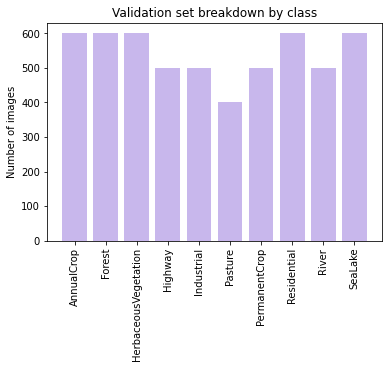

In [9]:

val_class_name_list = np.array(list(validation_set.class_indices.keys()))
val_labels, val_count = np.unique(validation_set.classes, return_counts=True)

#print(pd.Series(val_count, index=val_class_name_list))

val_objects = val_class_name_list
val_y_pos = np.arange(len(val_objects))
val_n_images = val_count

plt.bar(val_y_pos, val_n_images, align='center', alpha=0.5, color="mediumpurple")
plt.xticks(val_y_pos, val_class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Validation set breakdown by class')

plt.show()
#plt.savefig("/kaggle/working/exp1_val_classes.png")


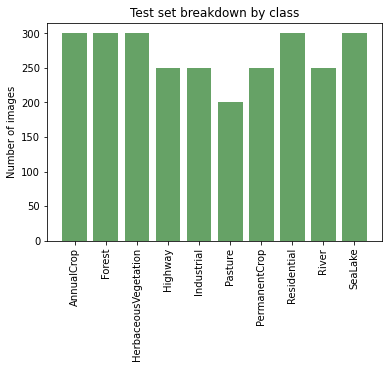

In [10]:
test_class_name_list = np.array(list(test_set.class_indices.keys()))
test_labels, test_count = np.unique(test_set.classes, return_counts=True)

# print(pd.Series(test_count, index=test_class_name_list))

test_objects = test_class_name_list
test_y_pos = np.arange(len(test_objects))
test_n_images = test_count

plt.bar(test_y_pos, test_n_images, align='center', alpha=0.6, color="darkgreen")
plt.xticks(test_y_pos, test_class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.title('Test set breakdown by class')

plt.show()
#plt.savefig("/kaggle/working/exp1_test_classes.png")

# CNNs

## ResNet50
Use pre-trained weight as they work better than randomly initializing them.
**You can experiment with that as well.**

In [11]:
base_resnet50 = ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(64, 64, 3),
                pooling=None,
                classes=10,
                classifier_activation='softmax',
            )

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
# base_resnet50.summary()
# import visualkeras
# visualkeras.layered_view(base_resnet50)
#plot_model(base_resnet50, to_file='model.png')

# STOPPED HERE

## Add custom layers to VGG16
From https://www.kaggle.com/code/rnogueras/keras-basic-toolbox-for-image-recognition/notebook:

For the final layers of the architecture we add:
- **dropout layer** to prevent overfitting of the convolutional base. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.
- a **He normal initializer** for the weights of the dense layer. It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.
- a **Softmax function** to produce the multiclass output.

In [13]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_resnet50)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 27,787,658
Trainable params: 27,734,538
Non-trainable params: 53,120
_________________________________________________________________


### Some improvements and Speed-ups:
**ModelCheckpoint**: Save the weigths of the best model

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

**EarlyStopping**: Stop training when a monitored metric has stopped improving.

In [14]:
model_path = "/kaggle/working/eurosat_rgb_resnet50_model.h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 15 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [15]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [16]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=40,
    verbose=1,
)

Epoch 1/40
148/148 [==============================] - 113s 665ms/step - loss: 0.5563 - accuracy: 0.8472 - val_loss: 89.4116 - val_accuracy: 0.1111


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
148/148 [==============================] - 28s 191ms/step - loss: 0.0815 - accuracy: 0.9728 - val_loss: 140.8280 - val_accuracy: 0.1111
Epoch 3/40
148/148 [==============================] - 28s 188ms/step - loss: 0.0247 - accuracy: 0.9915 - val_loss: 97.4843 - val_accuracy: 0.1111
Epoch 4/40
148/148 [==============================] - 28s 191ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 79.2623 - val_accuracy: 0.1220
Epoch 5/40
148/148 [==============================] - 29s 193ms/step - loss: 0.0132 - accuracy: 0.9954 - val_loss: 35.9042 - val_accuracy: 0.1902
Epoch 6/40
148/148 [==============================] - 29s 193ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 6.9935 - val_accuracy: 0.4539
Epoch 7/40
148/148 [==============================] - 28s 187ms/step - loss: 0.0102 - accuracy: 0.9962 - val_loss: 2.2246 - val_accuracy: 0.7324
Epoch 8/40
148/148 [==============================] - 28s 189ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.4126 - v

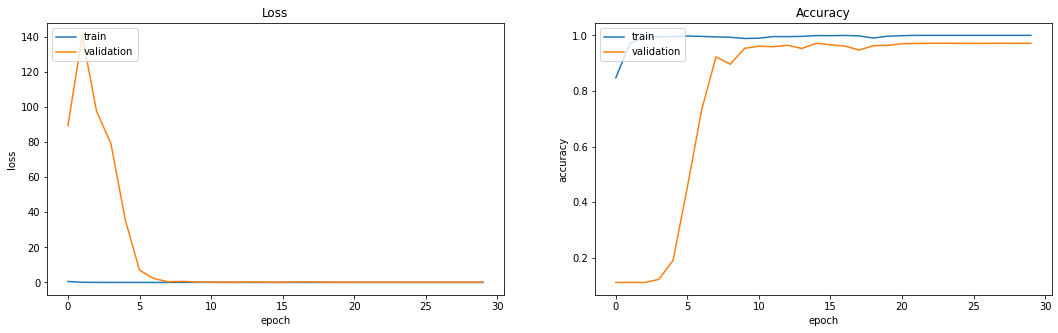

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig("/kaggle/working/exp1_resnet50_loss_accuracy.png")

The gap between training and validation accuracy indicates some level of overfitting. I could:
- try to **fit a simpler model** and see if that reduces the gap.
- Use [regularizers](https://keras.io/api/layers/regularizers/). Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

# Evaluate Model

In [18]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 11s 516ms/step - loss: 0.1319 - accuracy: 0.9741


In [19]:
print("Test Loss:", loss, "\nTest Accuracy:", accuracy)

Test Loss: 0.1318916380405426 
Test Accuracy: 0.9740740656852722


# Predict Test Set

In [20]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 4s 947us/step


In [21]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)

[[296   0   0   1   0   1   1   0   1   0]
 [  0 300   0   0   0   0   0   0   0   0]
 [  0   5 285   0   0   1   7   1   0   1]
 [  3   0   2 236   1   1   1   0   6   0]
 [  0   0   0   1 248   0   0   1   0   0]
 [  0   0   4   1   0 191   3   0   1   0]
 [  4   0   8   1   0   1 236   0   0   0]
 [  0   0   0   0   2   0   1 297   0   0]
 [  3   0   0   5   1   0   0   0 241   0]
 [  0   0   0   0   0   0   0   0   0 300]]


In [22]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

### Precision, Recall, and F1 by label

In [23]:
"""df = confusion_matrix_df
precision_scores = []
recall_scores = []
f1_scores = []

print("Precision scores for all labels:\n")

for i in range(len(df.columns)):
    current_column = df.columns[i]
    current_precision = df[current_column][i]/sum(df[current_column])
    print(f'{current_column}: {current_precision}')
    precision_scores.append(current_precision)

print("\nRecall scores for all labels:\n")

for i in range(len(cf_matrix)):
    current_row_name = df.index.values[i]
    current_recall = cf_matrix[i][i]/sum(cf_matrix[i])
    print(f'{current_row_name}: {current_recall}')
    recall_scores.append(current_recall)
    
print("\nF1 scores for all labels:\n")

for i in range(len(precision_scores)):
    current_precision = precision_scores[i]
    current_recall = recall_scores[i]
    current_f1 = 2*(current_precision*current_recall)/(current_precision+current_recall)
    f1_scores.append(current_f1)
    print(f'{df.columns[i]}: {current_f1}')
"""

'df = confusion_matrix_df\nprecision_scores = []\nrecall_scores = []\nf1_scores = []\n\nprint("Precision scores for all labels:\n")\n\nfor i in range(len(df.columns)):\n    current_column = df.columns[i]\n    current_precision = df[current_column][i]/sum(df[current_column])\n    print(f\'{current_column}: {current_precision}\')\n    precision_scores.append(current_precision)\n\nprint("\nRecall scores for all labels:\n")\n\nfor i in range(len(cf_matrix)):\n    current_row_name = df.index.values[i]\n    current_recall = cf_matrix[i][i]/sum(cf_matrix[i])\n    print(f\'{current_row_name}: {current_recall}\')\n    recall_scores.append(current_recall)\n    \nprint("\nF1 scores for all labels:\n")\n\nfor i in range(len(precision_scores)):\n    current_precision = precision_scores[i]\n    current_recall = recall_scores[i]\n    current_f1 = 2*(current_precision*current_recall)/(current_precision+current_recall)\n    f1_scores.append(current_f1)\n    print(f\'{df.columns[i]}: {current_f1}\')\n'

### Macro average scores

In [24]:
"""macro_average_precision = sum(precision_scores)/len(precision_scores)
macro_average_recall = sum(recall_scores)/len(recall_scores)
macro_average_f1 = sum(f1_scores)/len(f1_scores)

print(f'Macro average precision: {macro_average_precision}')
print(f'Macro average recall: {macro_average_recall}')
print(f'Macro average f1 score: {macro_average_f1}')
"""

"macro_average_precision = sum(precision_scores)/len(precision_scores)\nmacro_average_recall = sum(recall_scores)/len(recall_scores)\nmacro_average_f1 = sum(f1_scores)/len(f1_scores)\n\nprint(f'Macro average precision: {macro_average_precision}')\nprint(f'Macro average recall: {macro_average_recall}')\nprint(f'Macro average f1 score: {macro_average_f1}')\n"

### Evaluation scores

In [25]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))

              precision    recall  f1-score   support

           0     0.9673    0.9867    0.9769       300
           1     0.9836    1.0000    0.9917       300
           2     0.9532    0.9500    0.9516       300
           3     0.9633    0.9440    0.9535       250
           4     0.9841    0.9920    0.9880       250
           5     0.9795    0.9550    0.9671       200
           6     0.9478    0.9440    0.9459       250
           7     0.9933    0.9900    0.9917       300
           8     0.9679    0.9640    0.9659       250
           9     0.9967    1.0000    0.9983       300

    accuracy                         0.9741      2700
   macro avg     0.9737    0.9726    0.9731      2700
weighted avg     0.9740    0.9741    0.9740      2700



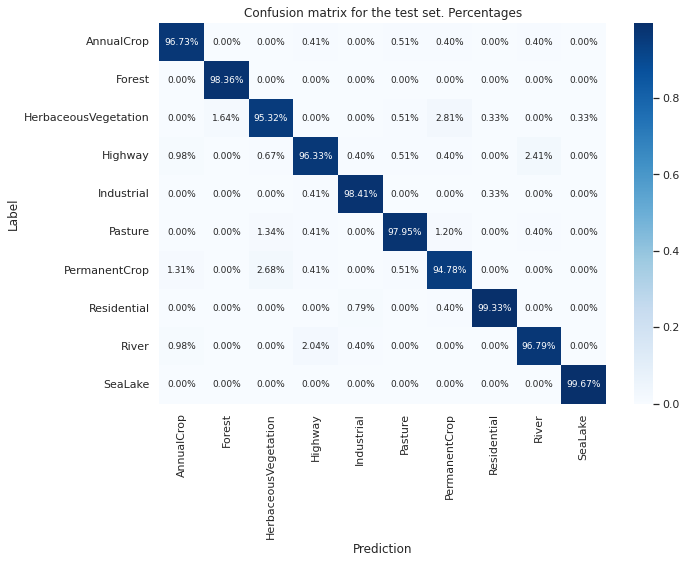

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/kaggle/working/resnet50_exp1_confusion_percentages.png")

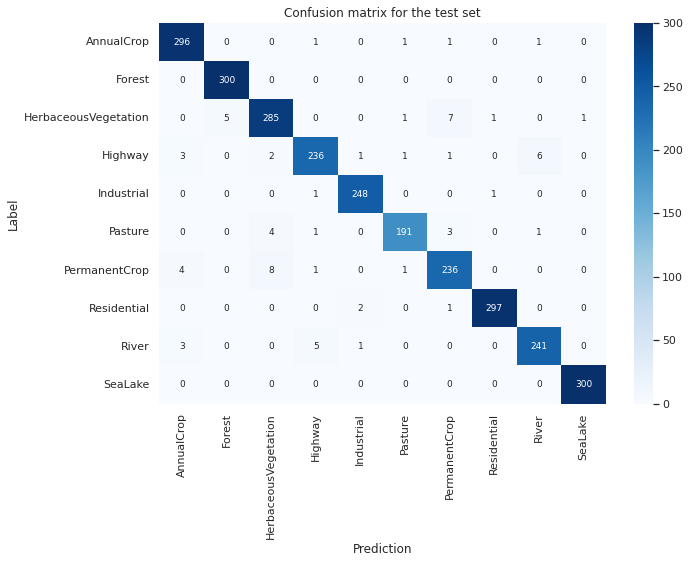

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig("/kaggle/working/resnet50_exp1_confusion.png")

In [28]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)


### Plot wrong predictions

In [29]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

70 wrong predictions out of 2700


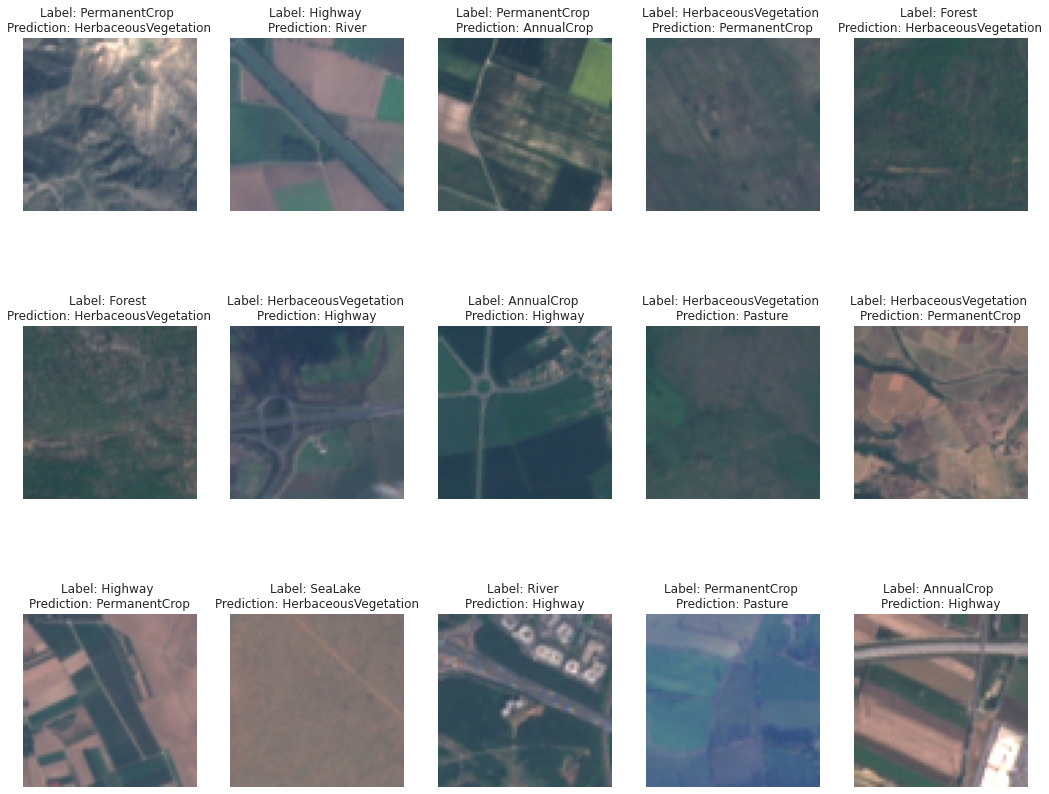

In [30]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("/kaggle/working/exp1_vgg19_mislabeled_results.png")